# 🚀 Nepali Tweet Classification - Complete Pipeline (FIXED)

**Classification**: Controversial vs Development Posts

**Model**: Rajan/NepaliBERT (PyTorch Compatible)

## ✅ All Issues Fixed:
- Correct PyTorch-compatible model
- Training + Validation accuracy tracking
- Updated parameter names (eval_strategy, num_items_in_batch)
- 15 comprehensive visualizations
- Party-wise analysis with percentages
- 3 training epochs

---

## 📦 Step 1: Installation and Setup

In [1]:
# Install required libraries
!pip install -q transformers[torch] datasets scikit-learn sentencepiece huggingface_hub emoji

print("✅ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.1 MB/s eta 0:00:00
✅ Installation complete!


In [2]:
# Authenticate with Hugging Face
from huggingface_hub import login

login()
print("✅ Hugging Face authentication complete!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Hugging Face authentication complete!


## 📚 Step 2: Import Libraries and Configuration

In [3]:
# Import all required libraries
import pandas as pd
import re
import emoji
import numpy as np
import torch
import random
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
    TrainerCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# ✅ CONFIGURATION - CORRECTED
SEED = 42
MODEL_NAME = "Rajan/NepaliBERT"  # ✅ FIXED: PyTorch-compatible Nepali BERT
MAX_LENGTH = 128
BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16
NUM_EPOCHS = 3  # ✅ 3 epochs as requested
LEARNING_RATE = 2e-5
TEST_SIZE = 0.2

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

print("="*60)
print("🔧 CONFIGURATION")
print("="*60)
print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print("="*60)
print("✅ Setup complete!")

🔧 CONFIGURATION
Device: cuda
Model: Rajan/NepaliBERT
Batch Size: 16
Epochs: 3
Learning Rate: 2e-05
✅ Setup complete!


## 📂 Step 3: Load and Clean Data

In [6]:
# Load dataset
df = pd.read_csv('combined_dataset_final_2.csv')

print(f"📊 Loaded {len(df)} tweets")
print(f"Columns: {df.columns.tolist()}")
display(df.head())

📊 Loaded 3624 tweets
Columns: ['tweet_id', 'party', 'username', 'name', 'date', 'time', 'full_text', 'like', 'retweet_count', 'reply_count', 'view_count', 'followers_count']


,tweet_id,party,username,name,date,time,full_text,like,retweet_count,reply_count,view_count,followers_count
0,1.73778E+18,CPN (SC),Bhanubhakta99,Bhanubhakta Joshi,12/21/2023,16:19:16,‘६०प्रतिशत विद्यार्थी स्कुल गएका छैनन्’ https:...,1,1,0,168,17
1,1.73778E+18,CPN (SC),Bhanubhakta99,Bhanubhakta Joshi,12/21/2023,16:16:43,RT @EduKhabar: सामुदायिक विद्यालयमा १० वर्ष पढ...,0,4,0,0,17
2,1.5313E+18,CPN (SC),Krishnacpnus,Krishna Kumar Shrestha,5/30/2022,21:35:49,https://t.co/yNDAB7elEU,1,0,1,0,69
3,1.5313E+18,CPN (SC),Krishnacpnus,Krishna Kumar Shrestha,5/30/2022,21:34:18,https://t.co/g97kWpTdnn,0,0,0,0,69
4,1.5313E+18,CPN (SC),Krishnacpnus,Krishna Kumar Shrestha,5/30/2022,21:34:07,https://t.co/C3eLyMYI9J,0,0,0,0,69


In [7]:
def clean_nepali_text(text):
    """Clean and preprocess Nepali text"""
    if pd.isna(text):
        return ""

    text = str(text)
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#', '', text)  # Remove mentions and hashtags
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    text = re.sub(r'[^A-Za-z\u0900-\u097F\s]', '', text)  # Keep only Devanagari and English
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    return text

print("🧹 Cleaning text data...")
df['cleaned_text'] = df['full_text'].apply(clean_nepali_text)
df = df[df['cleaned_text'].str.len() > 0].copy()

print(f"✅ Cleaning complete! {len(df)} tweets remaining")
print("\nSample cleaned texts:")
for i, text in enumerate(df['cleaned_text'].head(3), 1):
    print(f"{i}. {text[:100]}..." if len(text) > 100 else f"{i}. {text}")

🧹 Cleaning text data...
✅ Cleaning complete! 3449 tweets remaining

Sample cleaned texts:
1. ६०प्रतिशत विद्यार्थी स्कुल गएका छैनन्
2. RT सामुदायिक विद्यालयमा १० वर्ष पढाएपछि स्वतः बढुवा योग्यता तालिम र लाइसेन्स भएका प्राथमिक तहका शिक्...
3. नेपाली बौद्धमार्गी एवं हिमाली आदिवासी शेर्पा समुदायले मनाउने ग्याल्बो ल्होसार अर्थात् नयाँ वर्ष २१४९...


## 🏷️ Step 4: Automated Labeling with Teacher Model

In [8]:
print("🤖 Initializing teacher model for automated labeling...")

teacher = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
    device=0 if torch.cuda.is_available() else -1
)

candidate_labels = ["Controversial", "Development"]
print(f"✅ Teacher model loaded! Labels: {candidate_labels}")

🤖 Initializing teacher model for automated labeling...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7
Key                             | Status     |  | 
--------------------------------+------------+--+-
deberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

✅ Teacher model loaded! Labels: ['Controversial', 'Development']


In [9]:
# Sample and label data
sample_size = min(int(len(df) * 0.8), len(df))
sample_df = df.sample(sample_size, random_state=SEED).copy()

print(f"📊 Labeling {len(sample_df)} tweets...")

batch_size = 100
all_results = []

for i in tqdm(range(0, len(sample_df), batch_size), desc="Labeling batches"):
    batch_texts = sample_df['cleaned_text'].iloc[i:i+batch_size].tolist()
    batch_results = teacher(batch_texts, candidate_labels=candidate_labels)
    all_results.extend(batch_results)

sample_df['predicted_label'] = [result['labels'][0] for result in all_results]
sample_df['confidence'] = [result['scores'][0] for result in all_results]
label_map = {'Controversial': 0, 'Development': 1}
sample_df['label'] = sample_df['predicted_label'].map(label_map)

print("\n✅ Labeling complete!")
print(f"Label distribution:\n{sample_df['predicted_label'].value_counts()}")
print(f"Average confidence: {sample_df['confidence'].mean():.3f}")

📊 Labeling 2759 tweets...


Labeling batches:   0%|          | 0/28 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



✅ Labeling complete!
Label distribution:
predicted_label
Development      2105
Controversial     654
Name: count, dtype: int64
Average confidence: 0.720


In [10]:
# Clean up teacher model to free memory
del teacher
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("✅ Memory cleaned!")

✅ Memory cleaned!


## 🔄 Step 5: Prepare Training Data

In [11]:
# Load tokenizer
print(f"📥 Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✅ Tokenizer loaded!")

📥 Loading tokenizer: Rajan/NepaliBERT


config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✅ Tokenizer loaded!


In [12]:
# Split data
train_df, test_df = train_test_split(
    sample_df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=sample_df['label']
)

print("="*60)
print("📊 TRAIN-TEST SPLIT")
print("="*60)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("="*60)

📊 TRAIN-TEST SPLIT
Training samples: 2207
Test samples: 552


In [13]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

train_ds = Dataset.from_pandas(
    train_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'})
)
test_ds = Dataset.from_pandas(
    test_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'})
)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

print("✅ Data preparation complete!")

Map:   0%|          | 0/2207 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

✅ Data preparation complete!


## 🎯 Step 6: Training Setup with Accuracy Tracking

In [14]:
# ✅ Enhanced callback to track BOTH training and validation accuracy
class EnhancedMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.train_steps = []
        self.train_accuracies = []
        self.train_accuracy_steps = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.train_steps.append(state.global_step)

            if 'train_accuracy' in logs:
                self.train_accuracies.append(logs['train_accuracy'])
                self.train_accuracy_steps.append(state.global_step)

            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                self.eval_accuracies.append(logs.get('eval_accuracy', 0))
                self.eval_epochs.append(state.epoch)

metrics_callback = EnhancedMetricsCallback()
print("✅ Enhanced metrics callback initialized!")

✅ Enhanced metrics callback initialized!


In [15]:
# Load model
print(f"📥 Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# Define metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

print(f"✅ Model loaded on {device}!")

📥 Loading model: Rajan/NepaliBERT


pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: Rajan/NepaliBERT
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect iden

✅ Model loaded on cuda!


In [16]:
# ✅ Training arguments with FIXED parameter names
training_args = TrainingArguments(
    output_dir="./nepali_results",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=100,
    eval_strategy="epoch",  # ✅ FIXED: Changed from evaluation_strategy
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    seed=SEED,
    fp16=torch.cuda.is_available(),
)

print("✅ Training arguments configured!")

✅ Training arguments configured!


In [17]:
# ✅ Custom Trainer with FIXED compute_loss signature
class AccuracyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """✅ FIXED: Added num_items_in_batch parameter"""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = torch.nn.functional.cross_entropy(logits, labels)

        # Compute training accuracy
        preds = torch.argmax(logits, dim=-1)
        train_acc = (preds == labels).float().mean().item()

        # Log training accuracy
        self.log({"train_accuracy": train_acc})

        return (loss, outputs) if return_outputs else loss

# Initialize trainer
trainer = AccuracyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

print("✅ Trainer initialized with accuracy tracking!")

✅ Trainer initialized with accuracy tracking!


## 🚀 Step 7: Train the Model

In [18]:
print("="*60)
print("🚀 STARTING TRAINING")
print("="*60)

start_time = time.time()
train_result = trainer.train()
training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING COMPLETE")
print("="*60)
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Training loss: {train_result.training_loss:.4f}")
print("="*60)

🚀 STARTING TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.433803,0.369567,0.842391,0.841981,0.842391,0.842183
2,0.331143,0.359251,0.844203,0.846805,0.844203,0.845388
3,0.251027,0.381805,0.833333,0.835145,0.833333,0.834189


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


✅ TRAINING COMPLETE
Training time: 1.66 minutes
Training loss: 0.3374


## 💾 Step 8: Save Model

In [19]:
model_save_path = "./nepali_bert_final_model"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to: {model_save_path}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Model saved to: ./nepali_bert_final_model


## 📊 Step 9: Evaluate Model

In [20]:
eval_results = trainer.evaluate()

print("="*60)
print("📊 EVALUATION RESULTS")
print("="*60)
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key.replace('eval_', '').upper():.<30} {value:.4f}")
print("="*60)

📊 EVALUATION RESULTS
LOSS.......................... 0.3592
ACCURACY...................... 0.8442
PRECISION..................... 0.8468
RECALL........................ 0.8442
F1............................ 0.8454
RUNTIME....................... 0.7013
SAMPLES_PER_SECOND............ 787.1070
STEPS_PER_SECOND.............. 49.9070


In [21]:
# Get predictions
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

print("✅ Predictions generated!")

✅ Predictions generated!


## 📈 Step 10: Comprehensive Visualizations (15 Charts)

### Chart 1: Training Loss Over Steps

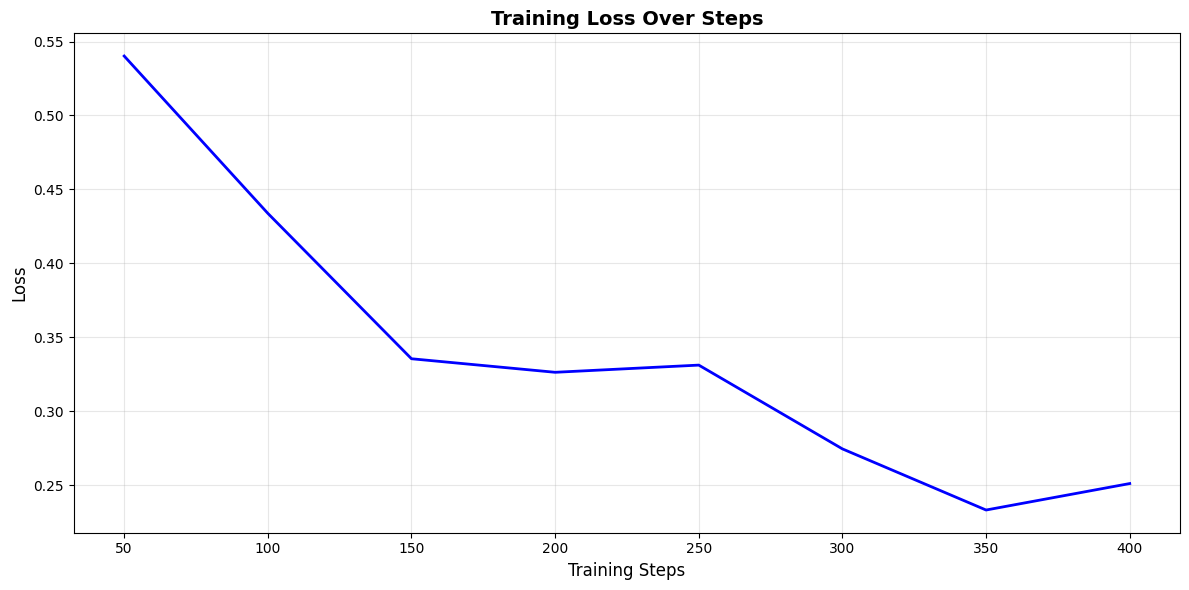

✅ Chart 1 saved


In [22]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.train_steps, metrics_callback.train_losses, 'b-', linewidth=2)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Steps', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('01_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Chart 1 saved")

### Chart 2: Training Accuracy Over Steps

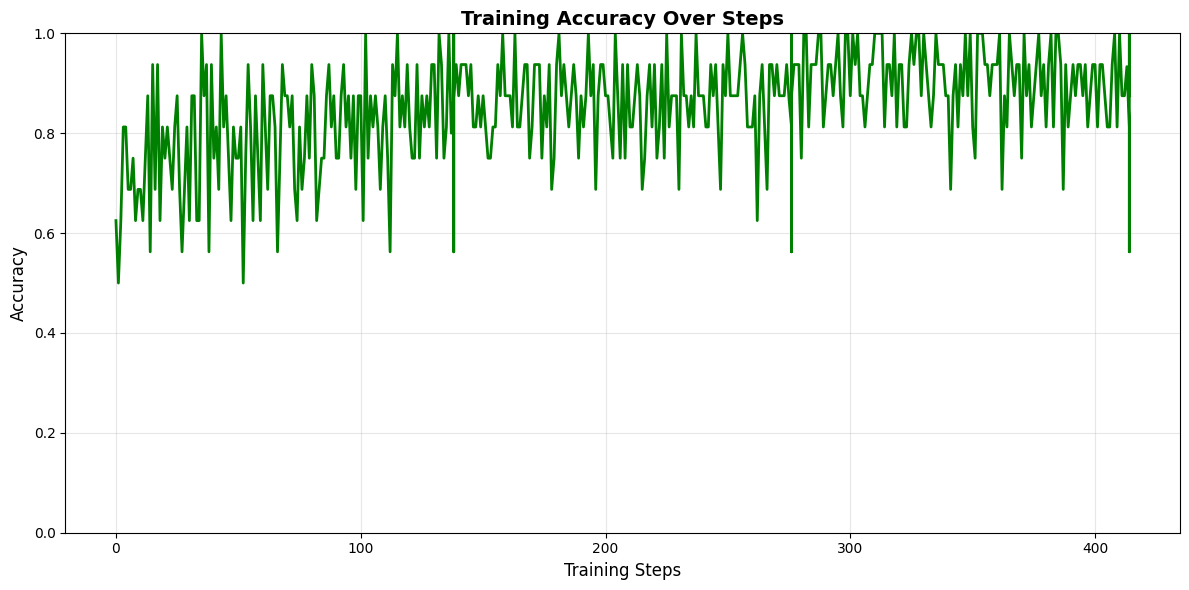

✅ Chart 2 saved


In [23]:
plt.figure(figsize=(12, 6))
if len(metrics_callback.train_accuracies) > 0:
    plt.plot(metrics_callback.train_accuracy_steps, metrics_callback.train_accuracies, 'g-', linewidth=2)
    plt.ylim(0, 1)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Steps', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('02_training_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Chart 2 saved")